# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# parse feature info

# transform X and XX to strings such that they can be used for later eval transform
feat_info_parsed = feat_info.copy()
feat_info_parsed['missing_or_unknown'] = feat_info_parsed['missing_or_unknown'].apply(lambda x: x.replace('XX]',"'XX']"))
feat_info_parsed['missing_or_unknown'] = feat_info_parsed['missing_or_unknown'].apply(lambda x: x.replace('X]',"'X']"))
feat_info_parsed['missing_or_unknown'] = feat_info_parsed['missing_or_unknown'].apply(lambda x: eval(x))

# check whether column elements are python lists now
print('feature info: '+feat_info['missing_or_unknown'][57])
print('parsed feature info: ',end='')
print(feat_info_parsed['missing_or_unknown'][57])

feature info: [-1,X]
parsed feature info: [-1, 'X']


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
def clean_dataframe(df):
    for column in df:
        mask = feat_info_parsed['attribute']==column
        missing_or_unknown_values = feat_info_parsed.loc[mask, 'missing_or_unknown'].values[0]
        missing_or_unknown_per_col = df[column].isin(missing_or_unknown_values)
        if df[missing_or_unknown_per_col].shape[0]>0:
            df.loc[missing_or_unknown_per_col , column] = np.nan
    return df

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_missing = azdias.isnull().sum() # natural missing values before the cleanup 
azdias_cleaned = clean_dataframe(azdias.copy()) # clean azdias data (i.e., replace unknown/missing with np.nan)
azdias_cleaned_missing = azdias_cleaned.isnull().sum() # incl. missing and unknowns after the cleanup 

# comparison of the final numbers
cleaning_compare = pd.concat([azdias_missing, azdias_cleaned_missing], axis=1)
cleaning_compare.rename(columns={0:'azdias_natural_missing',1:'azdias_cleaned_missing'},inplace=True)
cleaning_compare

,azdias_natural_missing,azdias_cleaned_missing
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 31.,   1.,   0.,   0.,   7.,  19.,  12.,   6.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([      0.  ,   17781.22,   35562.44,   53343.66,   71124.88,
          88906.1 ,  106687.32,  124468.54,  142249.76,  160030.98,
         177812.2 ,  195593.42,  213374.64,  231155.86,  248937.08,
         266718.3 ,  284499.52,  302280.74,  320061.96,  337843.18,
         355624.4 ,  373405.62,  391186.84,  408968.06,  426749.28,
         444530.5 ,  462311.72,  480092.94,  497874.16,  515655.38,
         533436.6 ,  551217.82,  568999.04,  586780.26,  604561.48,
         622342.7 ,  640123.92,  657905.14,  675686.36,  693467.58,
         711248.8 ,  729030.02,  746811.24,  764592.46,  782373.68,
         800154.9 ,  817936.12,  835717.34,  8

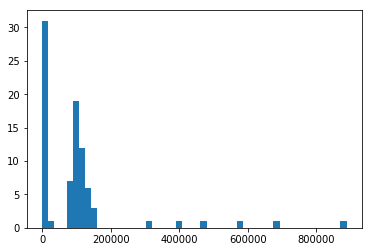

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values_per_column = azdias_cleaned.isnull().sum(axis=0)
x_columns = list(missing_values_per_column) 
label_columns = list(missing_values_per_column.keys())
plt.hist(x_columns, 50,label=label_columns)

In [11]:
# sort and check columns by absolute missing values
sorted_missing_values = cleaning_compare['azdias_cleaned_missing'].copy()
sorted_missing_values = sorted_missing_values.sort_values()
sorted_missing_values

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [12]:
# check how many percent of the respective columns are missing or unknown values
mask = missing_values_per_column > 0
num_of_rows = azdias_cleaned.shape[0]
missing_per_column = (missing_values_per_column[mask]/num_of_rows) * 100
missing_per_column.sort_values(inplace=True)
missing_per_column

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

In [13]:
# Investigate patterns in the amount of missing data in each column.
missing_values_groups = dict()
for key, value in sorted_missing_values.items():
    if value in missing_values_groups.keys():
        missing_values_groups[value].append(key)
    else:
        missing_values_groups[value] = [key]
        
# check quantiatively
for key, value in missing_values_groups.items():
    print(str(key)+" has "+str(len(value))+" items")

missing_values_groups

0 has 24 items
2881 has 1 items
4854 has 6 items
18348 has 1 items
73499 has 4 items
73969 has 1 items
77792 has 2 items
93148 has 4 items
93155 has 1 items
93740 has 3 items
94572 has 1 items
97008 has 1 items
97274 has 1 items
97375 has 2 items
97632 has 1 items
99352 has 3 items
99611 has 1 items
105800 has 1 items
108164 has 1 items
108315 has 1 items
111196 has 3 items
116515 has 7 items
133324 has 6 items
147988 has 1 items
158064 has 2 items
310267 has 1 items
392318 has 1 items
476524 has 1 items
584612 has 1 items
685843 has 1 items
889061 has 1 items


{0: ['ZABEOTYP',
  'SEMIO_TRADV',
  'SEMIO_PFLICHT',
  'SEMIO_KAEM',
  'SEMIO_DOM',
  'SEMIO_KRIT',
  'SEMIO_RAT',
  'SEMIO_KULT',
  'SEMIO_ERL',
  'SEMIO_LUST',
  'SEMIO_VERT',
  'SEMIO_MAT',
  'SEMIO_REL',
  'SEMIO_SOZ',
  'SEMIO_FAM',
  'FINANZ_VORSORGER',
  'ANREDE_KZ',
  'FINANZ_MINIMALIST',
  'FINANZ_SPARER',
  'FINANZ_ANLEGER',
  'FINANZ_UNAUFFAELLIGER',
  'FINANZ_HAUSBAUER',
  'GREEN_AVANTGARDE',
  'FINANZTYP'],
 2881: ['ALTERSKATEGORIE_GROB'],
 4854: ['GFK_URLAUBERTYP',
  'LP_STATUS_GROB',
  'LP_STATUS_FEIN',
  'ONLINE_AFFINITAET',
  'RETOURTYP_BK_S',
  'CJT_GESAMTTYP'],
 18348: ['HH_EINKOMMEN_SCORE'],
 73499: ['WOHNDAUER_2008', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_PERSONEN'],
 73969: ['KONSUMNAEHE'],
 77792: ['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN'],
 93148: ['OST_WEST_KZ', 'WOHNLAGE', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR'],
 93155: ['GEBAEUDETYP_RASTER'],
 93740: ['BALLRAUM', 'EWDICHTE', 'INNENSTADT'],
 94572: ['LP_LEBENSPHASE_GROB'],
 97008: ['ANZ_HH_TITEL'],
 97274: ['ORTSGR_KLS9'],
 973

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_cleaned_reduced = azdias_cleaned.copy()
columns_to_drop = ['GEBURTSJAHR','KBA05_BAUMAX','KK_KUNDENTYP','TITEL_KZ','AGER_TYP']
azdias_cleaned_reduced.drop(columns_to_drop, axis=1, inplace=True)
azdias_cleaned_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [15]:
# check how many missing/unknown values are reduced by the drop of the columns  
missing_before_drop = azdias_cleaned.isnull().sum().sum()
missing_after_drop = azdias_cleaned_reduced.isnull().sum().sum()
print('before drop: {:,} missing/unknown values'.format(missing_before_drop))
print('after drop: {:,} missing/unknown values'.format(missing_after_drop))
print('reduction by {:.3%}'.format((missing_before_drop-missing_after_drop)/missing_before_drop))

before drop: 8,373,929 missing/unknown values
after drop: 5,345,571 missing/unknown values
reduction by 36.164%


#### Discussion 1.1.2: Assess Missing Data in Each Column

#### observations regarding the amount of missing data in each column
The hist plot for columns as well as the analysis of how many perent per column are "missing or unknown values" shows that most columns lie in the range between 0-18% missing values. Columns that have more than these ~20% could be seen as outliers. Can be also seen in the hist plot since they are outside of the close to "gausian distribution". 

* ALTER_HH
* GEBURTSJAHR
* KBA05_BAUMX
* KK_KUNDENTYP
* TITEL_KZ
* AGER_TYP

#### Which columns were removed from the dataset?

In different resources I often came acrosse numbers such as 25%, 30%<sup>1</sup> or 50%<sup>2</sup>, 60% (only if var is insignificant)<sup>3</sup>, where people draw the line between "too many missing values" and often decide to drop these columns. However, they also most of the time state that this is highly dependent on the importance of the respective column


Since the two columns Geburtsjahr and Alter cover the same information i decided to draw the line there and set the boudary from which on I deleted the columns around 45% Additionally I saw that the column "Geburtsjahr" has more missing values than Alter_HH , which is why I decided to keep Alter_HH. 

The following were removee:
* **GEBURTSJAHR** (already contained by Alter_HH and other features later on)
* **KBA05_BAUMX** (since there is lots of other information encoded in e.g. all KB05 values, etc.) 
* **KK_KUNDENTYP** (already above 60%) 
* **TITEL_KZ** (too many missing values, no value/information contained)
* **AGER_TYP** (too many missing values, no value/information contained)

#### Are there any patterns in missing values?

By grouping all columns by the occurences of their missing/unknown I identified the following groups / patterns:
**Note:** only groups with at least 3 columns in it are listed here. The columns with no missing values are excluded. The number at the beginning of each line is the amount of missing/unknown values (after cleaning with np.nan).

* **4854**: CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEIN, LP_STATUS_GROB, RETOURTYP_BK_S, ONLINE_AFFINITAET
* **73499**: SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008
* **93148**: GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE
* **93740**: BALLRAUM, EWDICHTE, INNENSTADT
* **99352**: CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, 
* **111196**: HEALTH_TYP, SHOPPER_TYP, VERS_TYP, 
* **116515**: PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ
* **133324**: KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO

What I conclude from only looking at the features that usually related features are missing together, such as "BALLRAUM, EDWICHTE and INNENSTADT". Meaning if the information is not provided by one column it usually is also not provided by related columns. 

<sup>1</sup>
https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456/2
<sup>2</sup>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
<sup>3</sup>
https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](s://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](s://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  3.03770000e+04,   1.35292000e+05,   1.89850000e+05,
          1.33473000e+05,   1.10108000e+05,   7.16150000e+04,
          1.75020000e+04,   1.68080000e+04,   0.00000000e+00,
          1.54320000e+04,   1.15240000e+04,   1.49930000e+04,
          1.19430000e+04,   1.18650000e+04,   7.27000000e+03,
          2.45100000e+03,   2.69900000e+03,   0.00000000e+00,
          2.41600000e+03,   3.38100000e+03,   2.75400000e+03,
          1.79900000e+03,   1.27200000e+03,   1.25500000e+03,
          5.41000000e+02,   0.00000000e+00,   3.64000000e+02,
          2.57000000e+02,   2.16000000e+02,   1.30000000e+02,
          1.14000000e+02,   8.50000000e+01,   5.20000000e+01,
          2.50000000e+01,   0.00000000e+00,   2.90000000e+01,
          1.90000000e+01,   1.40000000e+01,   4.43000000e+02,
          2.53400000e+03,   4.44500000e+03,   3.97500000e+03,
          0.00000000e+00,   2.31600000e+03,   2.72400000e+03,
          2.06500000e+03,   2.62000000e+02,   1.60000000e+02,
        

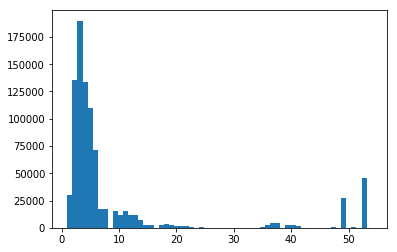

In [16]:
# How much data is missing in each row of the dataset?
missing_values_per_row = azdias_cleaned.isnull().sum(axis=1)
x_rows = list(missing_values_per_row[missing_values_per_row>0]) 
plt.hist(x_rows, 60)

(array([  1.76957000e+05,   3.06400000e+04,   1.81020000e+04,
          1.65110000e+04,   0.00000000e+00,   1.73830000e+04,
          1.71390000e+04,   1.01280000e+04,   2.00870000e+04,
          0.00000000e+00,   1.33940000e+04,   4.91100000e+03,
          2.42500000e+03,   9.96000000e+02,   0.00000000e+00,
          2.87600000e+03,   2.17600000e+03,   4.39500000e+03,
          2.74000000e+03,   0.00000000e+00,   1.25700000e+03,
          5.25000000e+02,   1.04300000e+03,   4.75000000e+02,
          0.00000000e+00,   2.48000000e+02,   1.34000000e+02,
          1.26000000e+02,   1.18000000e+02,   0.00000000e+00,
          6.10000000e+01,   5.60000000e+01,   2.80000000e+01,
          2.30000000e+01,   0.00000000e+00,   9.00000000e+00,
          7.00000000e+00,   4.00000000e+00,   1.86000000e+02,
          0.00000000e+00,   2.51800000e+03,   8.47900000e+03,
          4.54000000e+03,   2.21100000e+03,   0.00000000e+00,
          5.01000000e+02,   3.93000000e+02,   1.97000000e+02,
        

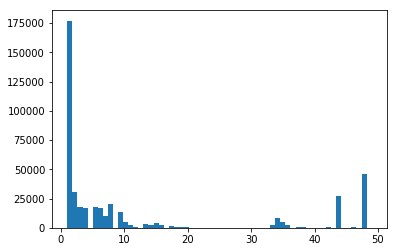

In [17]:
# How much data is missing in each row of the dataset?
missing_values_per_row_reduced = azdias_cleaned_reduced.isnull().sum(axis=1)
x_rows_reduced = list(missing_values_per_row_reduced[missing_values_per_row_reduced>0]) 
plt.hist(x_rows_reduced, 60)

In [18]:
# simple statistics
for key, value in {'whole data set':missing_values_per_row,'reduced data set':missing_values_per_row_reduced}.items():
    print('statistics for the '+key)
    q25 = value.quantile(q=0.25)
    q50 = value.median()
    q75 = value.quantile(q=0.75)
    print("# Q1: "+str(q25))
    print("# Q2 (median): "+str(q50))
    print("# Q3: "+str(q75))
    iqr = q75-q25
    print("# IQR: "+str(iqr))
    lower_bound = q25-(1.5*iqr)
    upper_bound = q75+(1.5*iqr)
    print("# lower bound: "+str(lower_bound))
    print("# upper bound: "+str(upper_bound))
    print()

statistics for the whole data set
# Q1: 3.0
# Q2 (median): 4.0
# Q3: 6.0
# IQR: 3.0
# lower bound: -1.5
# upper bound: 10.5

statistics for the reduced data set
# Q1: 0.0
# Q2 (median): 0.0
# Q3: 3.0
# IQR: 3.0
# lower bound: -4.5
# upper bound: 7.5



In [19]:
missing_value_row_threshold = 20 # 25%

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# devide based on stats of whole data set 
below_threshold_mask = azdias_cleaned_reduced.isnull().sum(axis=1) <= missing_value_row_threshold
above_threshold_mask = azdias_cleaned_reduced.isnull().sum(axis=1) > missing_value_row_threshold
subset_below_threshold = azdias_cleaned_reduced[below_threshold_mask].copy().reset_index(drop=True)
subset_above_threshold = azdias_cleaned_reduced[above_threshold_mask].copy().reset_index(drop=True)
subset_below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797253 entries, 0 to 797252
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     794472 non-null float64
ANREDE_KZ                797253 non-null int64
CJT_GESAMTTYP            792620 non-null float64
FINANZ_MINIMALIST        797253 non-null int64
FINANZ_SPARER            797253 non-null int64
FINANZ_VORSORGER         797253 non-null int64
FINANZ_ANLEGER           797253 non-null int64
FINANZ_UNAUFFAELLIGER    797253 non-null int64
FINANZ_HAUSBAUER         797253 non-null int64
FINANZTYP                797253 non-null int64
GFK_URLAUBERTYP          792620 non-null float64
GREEN_AVANTGARDE         797253 non-null int64
HEALTH_TYP               760861 non-null float64
LP_LEBENSPHASE_FEIN      747669 non-null float64
LP_LEBENSPHASE_GROB      750480 non-null float64
LP_FAMILIE_FEIN          766185 non-null float64
LP_FAMILIE_GROB          766185 non-null float64
LP_STATUS_FEIN           792620 non-null float64
LP_STATUS_GROB           

In [21]:
# rows in subsets
rows_below_threshold = subset_below_threshold.shape[0]
rows_above_threshold = subset_above_threshold.shape[0]
rows_total = azdias.shape[0]
rows_below_percent = rows_below_threshold/rows_total
rows_above_percent = rows_above_threshold/rows_total

# stats to missing values 
missing_total_below_threshold = subset_below_threshold.isnull().sum().sum()
missing_total_above_threshold = subset_above_threshold.isnull().sum().sum()
total_missing = missing_total_below_threshold+missing_total_above_threshold
below_threshold_percent = missing_total_below_threshold/total_missing
above_threshold_percent = missing_total_above_threshold/total_missing

print("rows in below the threshold subset: {} ({:.1%})".format(rows_below_threshold, rows_below_percent))
print("rows in below the threshold subset: {} ({:.1%})".format(rows_above_threshold, rows_above_percent))
print("total missing below threshold: {} ({:.1%})".format(missing_total_below_threshold,below_threshold_percent))
print("total missing above threshold: {} ({:.1%})".format(missing_total_above_threshold,above_threshold_percent))

rows in below the threshold subset: 797253 (89.5%)
rows in below the threshold subset: 93968 (10.5%)
total missing below threshold: 1225964 (22.9%)
total missing above threshold: 4119607 (77.1%)


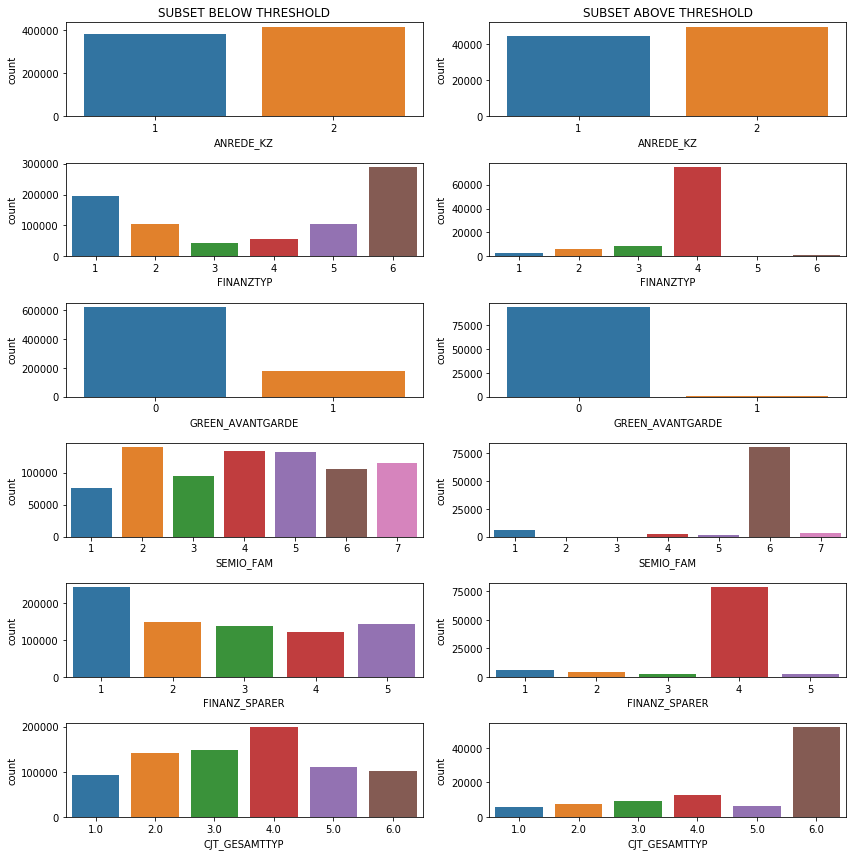

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare(columns_to_compare):
    fig, axs = plt.subplots(len(columns_to_compare), 2, figsize=(12,12))
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    axs = axs.ravel()

    for idx, column in enumerate(columns_to_compare):
        pl_idx = idx*2
        sns.countplot(subset_below_threshold[column], ax=axs[pl_idx])
        sns.countplot(subset_above_threshold[column], ax=axs[pl_idx+1])
    
    axs[0].set_title('SUBSET BELOW THRESHOLD')
    axs[1].set_title('SUBSET ABOVE THRESHOLD')
    
    fig.tight_layout()
    
compare(['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE','SEMIO_FAM','FINANZ_SPARER','CJT_GESAMTTYP'])

#### Discussion 1.1.3: Assess Missing Data in Each Row

####  observations regarding missing data in rows.

* From the stats we know that 50% of the rows have 0 to 4 missing/unknown values in the whole dataset 
* In the dataset with removed columns (columns with above 45% missing/unknown values) it is 0-1 
* In terms of distribution the visual majority of the data is below 20 missing values per row
* One can also see that there are outliers / a lot or rows with a lot of missing values such as 40 / 50 and 60
* From the histogramm for the whole dataset we see that most row with missing values have between 0 and 4 missing values, while for the reduced dataset it is 0-1

#### Are the data with lots of missing values are qualitatively different from data with few or no missing values?

* Whenever the column has a True or False (0,1) as potential values the difference is relatively small.
* As soon as the number of values in the respective column is greater than 2 a more significant difference in the distribution of values can be seen.
* However, except for a over representation of 1-2 values the relative occurences are similarily distributed. 
* **Conclusion**: I would not use two subsets with this data since iMo the distributions are not similar enough and one can see that with an increasing number of missing values a very defined group of people becomes visible (starting at 20 missing values upward). Thus, the missingness is systemic. 

A person with the following attributes:
* SEMIO_FAM: low afinity to a family
* FINANZSPARER: low 
* CJT_GESAMTTYP: Advertising-Enthusiast with restricted Cross-Channel-Behaviour
* GREEN AVANTGARDE: not a member of green avantgarde
* ANREDE_KZ: shows that its evenly distributed in terms of male/female

For this reason I in retrospect I picked 20 as a threshhold for the dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feature_mask = feat_info['type']=='categorical'
categorical_columns = feat_info.loc[feature_mask,'attribute']
categorical_columns
categorical_counts = dict()

for column in categorical_columns:
    if column in subset_below_threshold:
        no_of_val = len(subset_below_threshold[column].value_counts())
        no_of_missing = subset_below_threshold[column].isnull().sum()
        categorical_counts[column]=[no_of_val,no_of_missing]
categorical_counts

{'ANREDE_KZ': [2, 0],
 'CJT_GESAMTTYP': [6, 4633],
 'FINANZTYP': [6, 0],
 'GFK_URLAUBERTYP': [12, 4633],
 'GREEN_AVANTGARDE': [2, 0],
 'LP_FAMILIE_FEIN': [11, 31068],
 'LP_FAMILIE_GROB': [5, 31068],
 'LP_STATUS_FEIN': [10, 4633],
 'LP_STATUS_GROB': [5, 4633],
 'NATIONALITAET_KZ': [3, 33611],
 'SHOPPER_TYP': [4, 36392],
 'SOHO_KZ': [2, 0],
 'VERS_TYP': [2, 36392],
 'ZABEOTYP': [6, 0],
 'GEBAEUDETYP': [7, 0],
 'OST_WEST_KZ': [2, 0],
 'CAMEO_DEUG_2015': [9, 5903],
 'CAMEO_DEU_2015': [44, 5903]}

In [25]:
# check binary columns for values that are not numerical > identified ost_west_kz as the one
subset_below_threshold['OST_WEST_KZ'][:5]

0    W
1    W
2    W
3    W
4    W
Name: OST_WEST_KZ, dtype: object

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

# binary var wihtout numerical values OST_WEST_KZ
subset_below_threshold['OST_WEST_KZ'].replace('O',0,inplace=True)
subset_below_threshold['OST_WEST_KZ'].replace('W',1,inplace=True)
subset_below_threshold['OST_WEST_KZ'].value_counts() # check whether it worked

1    628848
0    168405
Name: OST_WEST_KZ, dtype: int64

In [27]:
# drop all categorical columns with more than 2 values that shall not be one-hot-encoded 
decided_to_drop = ['GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_STATUS_FEIN',
                   'CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015']
# drop all columns
subset_below_threshold.drop(decided_to_drop, axis=1,inplace=True)

In [28]:
# prepare for one hot encoding and replace np.nan back to 0 
for column in ['CJT_GESAMTTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ']:
        subset_below_threshold[column].fillna(0,inplace=True)
subset_below_threshold['SHOPPER_TYP'].fillna(1,inplace=True)

In [29]:
# remove outlier for gebaeudetyp 
subset_below_threshold.drop(subset_below_threshold[subset_below_threshold['GEBAEUDETYP'] == 5.0].index, inplace=True)

In [30]:
# one-hot-encode remai5ning categorical rows

def one_hot_encode(columns, df):
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    # encode and add new columns
    for column in columns:
        X =  df[column].values.reshape(-1,1)
        data = encoder.fit(X)
        data = encoder.transform(X)
        dfOneHot = pd.DataFrame(data.toarray(), columns=[column+"_"+str(int(i)) for i in range(data.shape[1])])
        df = df.join(dfOneHot)
        
        # drop original column
        df.drop(column, axis=1,inplace=True)
    
    # drop original columns
    return df


subset_below_threshold_encoded = one_hot_encode(['CJT_GESAMTTYP',
                                                 'FINANZTYP',
                                                 'LP_FAMILIE_GROB',
                                                 'LP_STATUS_GROB',
                                                 'NATIONALITAET_KZ',
                                                 'SHOPPER_TYP',
                                                 'ZABEOTYP',
                                                 'GEBAEUDETYP'], subset_below_threshold.copy())

subset_below_threshold_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797252 entries, 0 to 797252
Columns: 112 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_5
dtypes: float64(88), int64(23), object(1)
memory usage: 707.3+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Assumptions 

* the goal would be to find a balance between number of added columns and the information added
* while the added columns should not contain many missing values 

#### Decisions

##### Dropped Columns:
**Note**: even if it would be fairly simple to drop the columns, i've read that keeping as much data as possible is always preferable. Therefore I try to find a silver bullet solution where I keep all the columns that will not inflate the data set all too much and drop the ones that would lead to a big increase in no. of columns. 

* **GFK_URLAUBERTYP** 12 - 0 - dropped, since 12 columns would also unecesarily increase the number of columns
* **LP_FAMILIE_FEIN** 11 - 0 - dropped, since OHE would increase the number of columns and there also is a "grob" > general column
* **LP_STATUS_FEIN** 10 - 0 - dropped, since OHE would increase the number of columns and there also is a "grob" > general column
* **NATIONALITAET_KZ** 3 - 4 - dropped, since ethically this could lead to discrimination 
* **CAMEO_DEUG_2015** 9 - 83 - dropped - since OHE for 9 values would unecessarily increase the no. of columns
* **CAMEO_DEU_2015** 44 - 83 - dropped - since OHE for 44 values would unecessarily increase the no. of columns


##### One-Hot / Reencoded columns:

* **CJT_GESAMTTYP** 6 - 0 - OHE, since the type is probably interesting
* **FINANZTYP 6** - 0 - OHE - type is always interesting 
* **LP_FAMILIE_GROB** 5 - 0 - OHE, since the type is probably interesting 
* **LP_STATUS_GROB** 5 - 0 - OHE
* **SHOPPER_TYP** 4 - 4 - OHE, since the type is probably interesting
* **ZABEOTYP 6** - 0 - OHE, since the type is probably interesting
* **GEBAEUDETYP 6** - 0 - OHE, since the type is probably interesting
* **OST_WEST_KZ** - 2 i simply replaced the values for east and west with numerical values as stated in the introduction

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
feature_mask_mixed = feat_info['type']=='mixed'
mixed_columns = feat_info.loc[feature_mask_mixed,'attribute']
mixed_columns
mixed_counts = dict()

for column in mixed_columns:
    if column in subset_below_threshold_encoded:
        no_of_val = len(subset_below_threshold[column].value_counts())
        mixed_counts[column]=no_of_val
mixed_counts

{'LP_LEBENSPHASE_FEIN': 40,
 'LP_LEBENSPHASE_GROB': 12,
 'PRAEGENDE_JUGENDJAHRE': 15,
 'WOHNLAGE': 8,
 'CAMEO_INTL_2015': 21,
 'PLZ8_BAUMAX': 5}

In [32]:
mixed_columns_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PLZ8_BAUMAX']
subset_below_threshold_encoded.drop(mixed_columns_to_drop,axis=1,inplace=True)

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# subset_below_threshold_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()
    
def reengineer_column(df, old_column_name, new_columns):
    
    # add one new interval column
    def add_interval_column(new_column_name, old_values, new_interval_value):
        df.loc[df[old_column_name].isin(old_values), new_column_name]=new_interval_value

    # go through the different interval mappings for one new column
    def reencode_intervals(new_column_name, interval_mapping):
        for new_interval_value, old_values in interval_mapping.items():
            add_interval_column(new_column_name, old_values, new_interval_value)
    
    # go through all new columns and call subroutines 
    def add_interval_columns():
        for new_column_name, interval_mapping in new_columns.items():
            reencode_intervals(new_column_name, interval_mapping)
    
    # reengineer existing column by adding new columns with reengineered intervals  
    add_interval_columns()
    
    # drop original column
    df.drop([old_column_name],axis=1,inplace=True)
    

pj_new_columns = {
    'MOVEMENT': {
        1: [1,3,5,8,10,12,14],
        2: [2,4,6,7,9,11,13,15]
    },
    'DECADE': {
        1: [1,2], 
        2: [3,4],
        3: [5,6,7],
        4: [8,9],
        5: [10,11,12,13],
        6: [14,15]
    }
}
    
reengineer_column(subset_below_threshold_encoded, 'PRAEGENDE_JUGENDJAHRE',pj_new_columns)

subset_below_threshold_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 797252 entries, 0 to 797252
Columns: 110 entries, ALTERSKATEGORIE_GROB to DECADE
dtypes: float64(86), int64(23), object(1)
memory usage: 695.2+ MB


In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

ci2015_new_columns = {
    'WEALTH': {
        1: ['51','52','53','54','55'],
        2: ['41','42','43','44','45'],
        3: ['31','32','33','34','35'],
        4: ['21','22','23','24','25'],
        5: ['11','12','13','14','15']
    },
    'LIFE_STAGE': {
        1: ['11','21','31','41','51'], 
        2: ['12','22','32','42','52'],
        3: ['13','23','33','43','53'],
        4: ['14','24','34','44','54'],
        5: ['15','25','35','45','55']
    }
}

# since the values in the dataframe are strings and not integer values for a is in comparsion its necessary to convert them to 

reengineer_column(subset_below_threshold_encoded, 'CAMEO_INTL_2015', ci2015_new_columns)

subset_below_threshold_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797252 entries, 0 to 797252
Columns: 111 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(88), int64(23)
memory usage: 701.2 MB


In [35]:
# one hot encode WOHNLAGE
subset_below_threshold_encoded = one_hot_encode(['WOHNLAGE'], subset_below_threshold_encoded)

In [36]:
subset_below_threshold_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797252 entries, 0 to 797252
Columns: 118 entries, ALTERSKATEGORIE_GROB to WOHNLAGE_7
dtypes: float64(95), int64(23)
memory usage: 743.8 MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

#### Which one did you drop? (Removed Columns)

* LP_LEBENSPHASE_FEIN
* LP_LEBENSPHASE_GROB
* PLZ8_BAUMAX

since these variables concern the age, salary and household/buildung type which are already contained in other features in the data set. 

#### Which ones did you keep? (Reencoded)

* **PRAEGENDE_JUGENDJAHR**: created new columns MOVEMENT and DECADE and reencoded it according to the data dictionary
* **CAMEO_INTL_2015**: created new columns WEALTH and LIFE_STAGE and reencoded it according to the data dictionary
* **WOHNLAGE**: one hot encoded this column

At the end I dropped all the original columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# check which columns are in the dataset and which were excluded
feature_mask_check = feat_info['type'].isin(['numeric','interval','ordinal'])
check_columns = feat_info.loc[feature_mask_check,'attribute']
checked_columns = list()
excluded_columns = list()

for column in check_columns:
    if column in subset_below_threshold_encoded:
        no_of_val = len(subset_below_threshold[column].value_counts())
        checked_columns.append(column)
    else:
        excluded_columns.append(column)
        
print("The following "+str(len(checked_columns))+" numeric, interval or ordinal columns are in the dataset:")
print(checked_columns, end='\n\n')
print("The following "+str(len(excluded_columns))+" numeric, interval or ordinal columns were excluded:")
print(excluded_columns)

The following 56 numeric, interval or ordinal columns are in the dataset:
['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']

The following 1 numeric, interval or ordinal columns were

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
   
    # convert missing value codes into NaNs, ...
    df = clean_dataframe(df)
    
    # remove selected columns and rows, ...
    columns_to_drop = ['GEBURTSJAHR',
                       'KBA05_BAUMAX',
                       'KK_KUNDENTYP',
                       'TITEL_KZ',
                       'AGER_TYP',
                       'GFK_URLAUBERTYP',
                       'LP_FAMILIE_FEIN',
                       'LP_STATUS_FEIN',
                       'CAMEO_DEUG_2015',
                       'CAMEO_DEU_2015',
                       'LP_LEBENSPHASE_FEIN',
                       'LP_LEBENSPHASE_GROB',
                       'PLZ8_BAUMAX']
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    
    # select, re-encode, and engineer column values.
    
    
    # select 
    df = df[df.isnull().sum(axis=1)<=missing_value_row_threshold].copy().reset_index(drop=True)
    
    # reencode
    df['OST_WEST_KZ'].replace('O',0,inplace=True)
    df['OST_WEST_KZ'].replace('W',1,inplace=True)
    reengineer_column(df, 'PRAEGENDE_JUGENDJAHRE',pj_new_columns)
    reengineer_column(df, 'CAMEO_INTL_2015', ci2015_new_columns)
    
    # prepare for one hot encoding and replace np.nan back to 0 
    for column in ['CJT_GESAMTTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ']:
        df[column].fillna(0,inplace=True)
    df['SHOPPER_TYP'].fillna(1,inplace=True)
    
    df = one_hot_encode(['CJT_GESAMTTYP',
                         'FINANZTYP',
                         'LP_FAMILIE_GROB',
                         'LP_STATUS_GROB',
                         'NATIONALITAET_KZ',
                         'SHOPPER_TYP',
                         'ZABEOTYP',
                         'GEBAEUDETYP',
                         'WOHNLAGE'], 
                        df
                       )
    
    # Return the cleaned dataframe.
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# sanity check looks good after the cleaning the number of missing values still makes sense
cols_with_missing = subset_below_threshold_encoded.isnull().sum()[subset_below_threshold_encoded.isnull().sum()>0]

for col in cols_with_missing.items():
    col_name = col[0]
    col_type =  feat_info[feat_info['attribute']==col_name]['type'].values[0] if col_name in feat_info['attribute'].values else ''
    col_missing = col[1]
    print(col_name+" "+str(col_missing)+" "+col_type)

ALTERSKATEGORIE_GROB 2781 ordinal
HEALTH_TYP 36392 ordinal
RETOURTYP_BK_S 4633 ordinal
VERS_TYP 36392 categorical
ALTER_HH 229961 interval
W_KEIT_KIND_HH 58827 ordinal
ANZ_HAUSHALTE_AKTIV 6306 numeric
ANZ_HH_TITEL 3705 numeric
KONSUMNAEHE 65 ordinal
KBA05_ANTG1 39368 ordinal
KBA05_ANTG2 39368 ordinal
KBA05_ANTG3 39368 ordinal
KBA05_ANTG4 39368 ordinal
KBA05_GBZ 39368 ordinal
BALLRAUM 590 ordinal
EWDICHTE 590 ordinal
INNENSTADT 590 ordinal
GEBAEUDETYP_RASTER 5 ordinal
KKK 64303 ordinal
MOBI_REGIO 39368 ordinal
ONLINE_AFFINITAET 4633 ordinal
REGIOTYP 64303 ordinal
KBA13_ANZAHL_PKW 12140 numeric
PLZ8_ANTG1 22557 ordinal
PLZ8_ANTG2 22557 ordinal
PLZ8_ANTG3 22557 ordinal
PLZ8_ANTG4 22557 ordinal
PLZ8_HHZ 22557 ordinal
PLZ8_GBZ 22557 ordinal
ARBEIT 4218 ordinal
ORTSGR_KLS9 4118 ordinal
RELAT_AB 4218 ordinal
CJT_GESAMTTYP_0 1 
CJT_GESAMTTYP_1 1 
CJT_GESAMTTYP_2 1 
CJT_GESAMTTYP_3 1 
CJT_GESAMTTYP_4 1 
CJT_GESAMTTYP_5 1 
CJT_GESAMTTYP_6 1 
FINANZTYP_0 1 
FINANZTYP_1 1 
FINANZTYP_2 1 
FINANZTYP

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

subset_below_threshold_imputed = subset_below_threshold_encoded.copy()

# numeric features with np.nan will be replaced with the median 
numeric_cols_to_imp = ['ALTER_HH', 
                       'W_KEIT_KIND_HH', 
                       'ANZ_HAUSHALTE_AKTIV',
                       'ANZ_HH_TITEL',
                       'KBA13_ANZAHL_PKW'
                      ]
numeric_imputer = Imputer(missing_values=np.nan , strategy='median', axis=0)
impute_numeric_cols = subset_below_threshold_imputed[numeric_cols_to_imp]
imputed_numeric_cols = numeric_imputer.fit_transform(impute_numeric_cols)
subset_below_threshold_imputed[numeric_cols_to_imp] = imputed_numeric_cols

# most frequent for ordinal which have 0 already as a value
ordinal_cols_to_imp = ['KBA05_ANTG1', 
                       'KBA05_ANTG2', 
                       'KBA05_ANTG3',
                       'KBA05_ANTG4',
                       'KBA05_GBZ',
                       'BALLRAUM',
                       'EWDICHTE',
                       'INNENSTADT',
                       'GEBAEUDETYP_RASTER',
                       'MOBI_REGIO',
                       'PLZ8_ANTG1',
                       'PLZ8_ANTG2',
                       'PLZ8_ANTG3',
                       'PLZ8_ANTG4',
                       'PLZ8_HHZ',
                       'PLZ8_GBZ',
                       'ARBEIT',
                       'ORTSGR_KLS9',
                       'RELAT_AB'
                      ]
ordinal_imputer = Imputer(missing_values=np.nan , strategy='most_frequent', axis=0)
impute_ordinal_cols = subset_below_threshold_imputed[ordinal_cols_to_imp]
imputed_ordinal_cols = ordinal_imputer.fit_transform(impute_ordinal_cols)
subset_below_threshold_imputed[ordinal_cols_to_imp] = imputed_ordinal_cols

# reencode missing with value 0, when its still available 
subset_below_threshold_imputed.fillna(0,inplace=True)

In [42]:
feature_mask = feat_info['type']=='categorical'
categorical_columns = feat_info.loc[feature_mask,'attribute']
categorical_columns
categorical_counts = dict()

for column in categorical_columns:
    if column in subset_below_threshold_imputed:
        no_of_val = len(subset_below_threshold_imputed[column].value_counts())
        no_of_missing = subset_below_threshold_imputed[column].isnull().sum()
        categorical_counts[column]=[no_of_val,no_of_missing]
categorical_counts

{'ANREDE_KZ': [2, 0],
 'GREEN_AVANTGARDE': [2, 0],
 'SOHO_KZ': [2, 0],
 'VERS_TYP': [3, 0],
 'OST_WEST_KZ': [2, 0]}

In [43]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
subset_below_threshold_scaled = pd.DataFrame(scaler.fit_transform(subset_below_threshold_imputed.copy()))

### Discussion 2.1: Apply Feature Scaling

I first investigated which features have missing values and obtained the following list: 

* ALTER_HH               170116
* W_KEIT_KIND_HH           5010
* ANZ_HAUSHALTE_AKTIV       594
* KONSUMNAEHE                23
* KBA13_ANZAHL_PKW          295
* MOVEMENT                  918
* DECADE                    918

I then applied the following operations: 

* For numeric features that already have 0 as a value in their range I replaced the np.nan with the median as a quick and simple solution
* For the remaining features that do not yet have 0 in their ranges, I "reencoded" the missingness by 0 again, since I read that let such values encoded as 0 is actually better than replacing them with median or any other e.g., most frequent value. 

#### Resources
* https://www.researchgate.net/post/Is_it_better_to_delete_cases_with_missing_values_or_to_impute_missing_values_with_expectation_maximization_method
* https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87
* https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
* https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/245
* https://stats.stackexchange.com/questions/167829/how-do-we-decide-on-how-to-fill-missing-values-in-data
* https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.

def do_pca(data, n_components=-1):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''

    if n_components == -1:
        pca = PCA() # keep all compontents
    else:
        pca = PCA(n_components)
    
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [45]:
pca, subset_below_threshold_pca = do_pca(subset_below_threshold_scaled) 

In [46]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=6)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

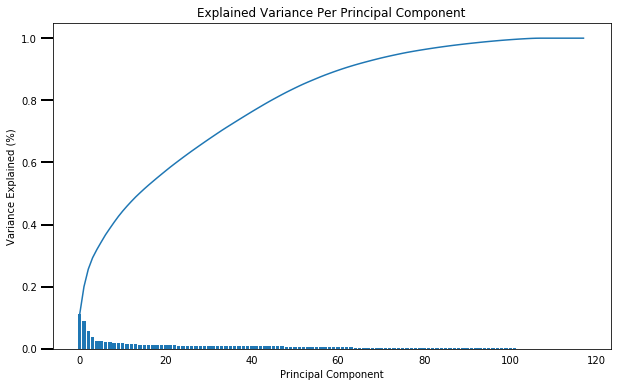

In [47]:
scree_plot(pca) # judging from this the 85% must lay somewhere between 40 and 50 components

In [48]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


In [49]:
def explainVariabbility(df): 
    for comp in range(53,59):
        pca, X_pca = do_pca(df, comp)
        comp_check = pca_results(df, pca)
        if comp_check['Explained Variance'].sum() > 0.85:
            break
        
    num_comps = comp_check.shape[0]
    print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

In [50]:
# explainVariabbility(subset_below_threshold_scaled) #Using 49 components, we can explain 0.8489% of the variability in the original data.

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, subset_below_threshold_pca = do_pca(subset_below_threshold_scaled, 53)

### Discussion 2.2: Perform Dimensionality Reduction

#### findings and decisions regarding dimensionality reduction 

1. I first added a slightly modified version of the do_pca() function from the previous lesson and used it to do the actual pca calculation withoout a given number of components (I later also used in this function in the explainVariability function). 
2. I then used the result of step 1 and created a scree plot (provided by the helpers in the previous lessons as well) to visually find the point where the reduced components can still explain 85% of the data (for the sake of simplicity I kept the same threshold).   
3. I then applied the helper function explainVariability to find the 85% spot quantitatively too.  

#### How many principal components / transformed features are you retaining for the next step of the analysis?)

This resulted in 53 components to keep, which I then reapplied to the data using the do_pca function in order to get the final components for further steps. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, df, index):
    
    weights = dict()
    
    for idx, key in enumerate(df.columns):
        weights[key] = pca.components_[index][idx]
    
    sorted_weights = sorted(weights.items(), key=lambda kv: kv[1], reverse=True)
    
    return sorted_weights

In [53]:
pca_weights(pca, subset_below_threshold_imputed,0)

[('LP_STATUS_GROB_1', 0.2030045352627691),
 ('PLZ8_ANTG3', 0.19217886053728711),
 ('HH_EINKOMMEN_SCORE', 0.18750495181504132),
 ('PLZ8_ANTG4', 0.18548715340529745),
 ('ORTSGR_KLS9', 0.17197140453469195),
 ('EWDICHTE', 0.16934224320838234),
 ('FINANZ_SPARER', 0.15031885071004666),
 ('FINANZ_HAUSBAUER', 0.14671524565595515),
 ('FINANZTYP_0', 0.13721629687717926),
 ('KBA05_ANTG4', 0.13403201043322924),
 ('PLZ8_ANTG2', 0.13239739220226707),
 ('ARBEIT', 0.12113468878410105),
 ('KBA05_ANTG3', 0.12107607423621489),
 ('ANZ_HAUSHALTE_AKTIV', 0.11936475913083995),
 ('SEMIO_PFLICHT', 0.11655263959189588),
 ('RELAT_AB', 0.11593261106659594),
 ('SEMIO_REL', 0.11250019850273525),
 ('SEMIO_RAT', 0.097793306469063618),
 ('ZABEOTYP_4', 0.090947427159075972),
 ('SEMIO_TRADV', 0.089544550071198256),
 ('FINANZ_UNAUFFAELLIGER', 0.083970244070979264),
 ('FINANZ_ANLEGER', 0.079990950089126836),
 ('REGIOTYP', 0.079113397699063559),
 ('DECADE', 0.078313165217658243),
 ('LP_FAMILIE_GROB_1', 0.076484054337447552

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(pca, subset_below_threshold_imputed,1)

[('ALTERSKATEGORIE_GROB', 0.22165400007159175),
 ('FINANZ_VORSORGER', 0.20972097487181915),
 ('ZABEOTYP_2', 0.20309710470676978),
 ('SEMIO_ERL', 0.18632277984647669),
 ('SEMIO_LUST', 0.16036919674420894),
 ('RETOURTYP_BK_S', 0.15232285534575823),
 ('W_KEIT_KIND_HH', 0.12937391310171892),
 ('FINANZ_HAUSBAUER', 0.11895746049875025),
 ('CJT_GESAMTTYP_2', 0.10450923389493644),
 ('FINANZTYP_4', 0.094650205091493078),
 ('PLZ8_ANTG3', 0.093367297523522269),
 ('PLZ8_ANTG4', 0.091201020380611925),
 ('ORTSGR_KLS9', 0.0907753611313981),
 ('EWDICHTE', 0.090516792225103018),
 ('SEMIO_KRIT', 0.088477689909847432),
 ('FINANZTYP_1', 0.082443857981462101),
 ('SEMIO_KAEM', 0.080657657035165448),
 ('KBA05_ANTG4', 0.073117913522834851),
 ('SHOPPER_TYP_3', 0.071325697746286956),
 ('ARBEIT', 0.069711658754784633),
 ('HH_EINKOMMEN_SCORE', 0.069209038520026744),
 ('CJT_GESAMTTYP_1', 0.068506002336143984),
 ('ANZ_HAUSHALTE_AKTIV', 0.065405340563302675),
 ('LP_FAMILIE_GROB_1', 0.065345007354655052),
 ('RELAT_AB

In [55]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(pca, subset_below_threshold_imputed,2)

[('SEMIO_VERT', 0.32597291381898502),
 ('SEMIO_SOZ', 0.25852245015711517),
 ('SEMIO_FAM', 0.25619023476732128),
 ('SEMIO_KULT', 0.24630600183012194),
 ('FINANZTYP_4', 0.13881323634796291),
 ('FINANZ_MINIMALIST', 0.1333944426869344),
 ('SHOPPER_TYP_0', 0.12662807216820277),
 ('ZABEOTYP_0', 0.10556891018384121),
 ('SEMIO_REL', 0.097008973564706003),
 ('RETOURTYP_BK_S', 0.085121795991283875),
 ('W_KEIT_KIND_HH', 0.081553396565680766),
 ('SEMIO_MAT', 0.075789601500308543),
 ('FINANZ_VORSORGER', 0.067581730060163506),
 ('ORTSGR_KLS9', 0.059220382069763884),
 ('MOVEMENT', 0.059019661358521866),
 ('EWDICHTE', 0.057858459734668299),
 ('GREEN_AVANTGARDE', 0.053921610245086161),
 ('ZABEOTYP_5', 0.052046352424159691),
 ('PLZ8_ANTG4', 0.050615914145028099),
 ('PLZ8_ANTG3', 0.050554493461206024),
 ('ARBEIT', 0.038526911198275858),
 ('VERS_TYP', 0.037472257208349527),
 ('RELAT_AB', 0.036438261817072111),
 ('LP_STATUS_GROB_5', 0.035857309504005667),
 ('ALTERSKATEGORIE_GROB', 0.035581871597320222),
 (

### Discussion 2.3: Interpret Principal Components

#### observations from detailed investigation of the first few principal components generated,  can we interpret positive and negative values from them in a meaningful way?

**Component 1**: is strongly influenced by financial data such as:
* LP_STATUS_GROB (income) 
* Einkomens Score (income)
* Finanzsparer, Finanzhausbauer
* Finanztyp
...

what can be immediately seen is that the strongest indicators are somewhat or directly related to income (e.g. LP_STATUS, Einkommens score, Finanztyp..) 

One negative relation can be found with e.g. LP_STATUS GROB and FINANZ_MINIMALIST, where The higher the income the less likel it is that one is a "FINANZ_MINIMALIST". If we compare the income information with another negative weigth such as for MOBI_REGIO, it would say that the higher the income the higher the movement pattern. (which kinda makes sense). 
Same holds true for the negative weight of WEALTH, if e.g. compared with W_KEIT_KIND_HH - the wealthier a person the smaller the number of kids in the household.  

**Component 2**: in this cluster people are included how are "smart" (energy consumption) and look-ahead ("Vorsorger") 
Also "event orientation" (semio-erl) as well as "sensuality" (semio-lust) have a big influence in this component. Or how people return ordered goods has a big or how many kids are in the household. 

In contrast to component 1 and its focus on financial properties, component 2 lays more weight on the characteristics of people.
One negative weight would be DECADE, which makes sense since the lower the value of the decade (from an early decade), the higher the number of the feature ALTERSKATEGORIE_GROB, which means the older

**Component 3:** 
With all the various SEMIO values, it would imply

the more a person is social/cultural/family minded the more likely the person is an external supplied hedonist in terms of shopping behavior (i.e., she/he shops for pleasure) 

interesting ist the negative weight of ANREDE_KZ, which would mean that the more you can apply the characteristics mentioned before the more likley the person is female.  

Other very interesting features with negative weights are all SEMIO_ prefixed features.
These would say that the more a person conforms with this "social", "cultural", "family" type of a person the less likely she/he is to be either be one of the following: 
* dominant
* combative
* rational
* event-driven
* critical 

Same holds true for "FINANZ_ANLEGER", which could imply that families / cultural people are more conservative with their money and do not invest but rather just save heir money. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [57]:
# Over a number of different cluster counget_kmeans_scorets...
'''
# run k-means clustering on the data and...
scores = list()
centers = list(range(1,30,5))

# compute the average within-cluster distances.
for center in centers:
    scores.append(get_kmeans_score(subset_below_threshold_pca, center))
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
'''

"\n# run k-means clustering on the data and...\nscores = list()\ncenters = list(range(1,30,5))\n\n# compute the average within-cluster distances.\nfor center in centers:\n    scores.append(get_kmeans_score(subset_below_threshold_pca, center))\n    \n# Investigate the change in within-cluster distance across number of clusters.\n# HINT: Use matplotlib's plot function to visualize this relationship.\n\nplt.plot(centers, scores, linestyle='--', marker='o', color='b');\nplt.xlabel('K');\nplt.ylabel('SSE');\nplt.title('SSE vs. K');\n"

In [59]:
# obtain scores 
#scores 

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_population = KMeans(n_clusters=20)
model_population = kmeans_population.fit_transform(subset_below_threshold_pca)
labels_population = kmeans_population.predict(subset_below_threshold_pca)

### Discussion 3.1: Apply Clustering to General Population

#### findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?

A clearly visible elbow does not exist in this case. 
Yet, the drop in the SEE starts to significantly change around 20 centroids, which can be seen when one looks at the following results of the scores variable: 

Analysis conducted with 20 centroids and threshold of missing values in row of 20
* **1**  - 81643077.264817819,
* **6**  - 63677430.93531353,
* **11** - 57594135.467053138,
* **16** - 54579586.45481386,
* **21** - 51726619.50981316, - converges around here
* **26** - 49853138.224627934
 
 
Analsis conducted with 7 centroids and threshold of missing values in row <= 1 (comparison)
* **1  centroid**  - SEE of 59885869.736356318, 
* **6  centroids** - SEE of 45069136.515432023 > dropped by ~6000000
* **11 centroids** - SEE of 41586207.004937865 > dropped by ~3500000 
* **16 centroids** - SEE of 39281818.059871517 > dropped by ~2300000 
* **21 centroids** - SEE of 37536720.014080457 > dropped by ~1700000 - starts to converge (visually around 18-19) 
* **26 centroids** - SEE of 36471383.536711879 > dropped by ~1100000 
* **27 centroids** - SEE of 36295309.972175948 > dropped by  ~170000
* **28 centroids** - SEE of 35628861.482609972 > dropped by  ~600000
* **29 centroids** - SEE of 35316993.218962118 > dropped by  ~300000

As a result I picked 20 centroids for the data set at hand since from then on the difference of SEE is negligible. 

#### For visual analysis: 

Both for the latter version, the curve is pretty much the same for 20 centroids and 20 missing values, only starting and ending with a higher SSE. 

##### For range 1,6,11,16,21,26
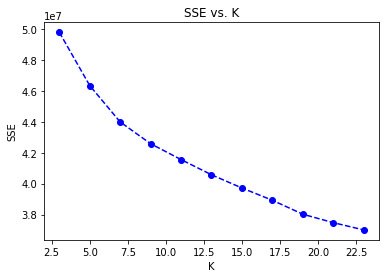

##### For range 3 - 25 with step size 2

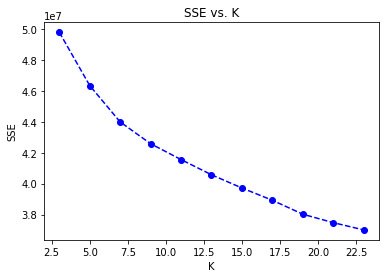

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# CLEAN DATA
subset_customers_cleaned = clean_data(customers.copy())


# IMPUTATION

subset_customers_imputed = subset_customers_cleaned.copy()

    # numeric features with np.nan will be replaced with the median 
numeric_customer_cols_to_impute = ['ALTER_HH', 
                                   'W_KEIT_KIND_HH', 
                                   'ANZ_HAUSHALTE_AKTIV',
                                   'ANZ_HH_TITEL',
                                   'KBA13_ANZAHL_PKW'
                             ]
impute_numeric_customer_cols = subset_customers_imputed[numeric_customer_cols_to_impute]
imputed_numeric_customer_cols = numeric_imputer.fit_transform(impute_numeric_customer_cols)
subset_customers_imputed[numeric_customer_cols_to_impute] = imputed_numeric_customer_cols

# most frequent for ordinal which have 0 already as a value
ordinal_customer_cols_to_impute = ['KBA05_ANTG1', 
                       'KBA05_ANTG2', 
                       'KBA05_ANTG3',
                       'KBA05_ANTG4',
                       'KBA05_GBZ',
                       'BALLRAUM',
                       'EWDICHTE',
                       'INNENSTADT',
                       'GEBAEUDETYP_RASTER',
                       'MOBI_REGIO',
                       'PLZ8_ANTG1',
                       'PLZ8_ANTG2',
                       'PLZ8_ANTG3',
                       'PLZ8_ANTG4',
                       'PLZ8_HHZ',
                       'PLZ8_GBZ',
                       'ARBEIT',
                       'ORTSGR_KLS9',
                       'RELAT_AB'
                      ]
impute_ordinal_customer_cols = subset_customers_imputed[ordinal_customer_cols_to_impute]
imputed_ordinal_customer_cols = ordinal_imputer.fit_transform(impute_ordinal_customer_cols)
subset_customers_imputed[ordinal_customer_cols_to_impute] = imputed_ordinal_customer_cols

    # reencode missing with value 0, since it is still available 
subset_customers_imputed.fillna(0,inplace=True)

#print(subset_customers_imputed.isnull().sum()[subset_customers_imputed.isnull().sum()>0])
##print(subset_customers_imputed.shape)

# SCALING - reusing the general population's StandardScaler object
subset_customers_scaled = pd.DataFrame(scaler.transform(subset_customers_imputed))

# PCA - using the general population's PCA object
subset_customers_pca = pca.transform(subset_customers_scaled)

# K-MEANS - reusing the general population's KMeans obbject 
labels_customers = kmeans_population.predict(subset_customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

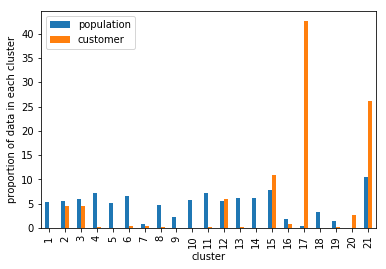

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

proportions_customers = list()
proportions_population = list()

len_pop = len(labels_population)#  same as shape of subset_below_threshold[0]
len_pop_rest = subset_above_threshold.shape[0]
len_pop_total = len_pop + len_pop_rest
len_cust = len(labels_customers) #  same as shape of subset_customers_cleaned[0]
len_cust_rest = customers.shape[0]-len_cust
len_cust_total = len_cust + len_cust_rest

# take excluded rows into account 
for index in range(0,20):
    proportions_population.append(((labels_population==index).sum()/len_pop_total)*100)
    proportions_customers.append(((labels_customers==index).sum()/len_cust_total)*100)

proportions_population.append(len_pop_rest/len_pop_total*100)
proportions_customers.append(len_cust_rest/len_cust_total*100)
    
df_proportions = pd.DataFrame({
    'cluster': [x for x in range(1,22)],
    'population': proportions_population,
    'customer': proportions_customers
})

# in order to overlay using matplotlib 
df_proportions.plot(x='cluster', y = ['population', 'customer'], kind='bar')
plt.ylabel('proportion of data in each cluster')
plt.show()

In [77]:
df_proportions

,cluster,customer,population
0,1,0.010957,5.305312
1,2,4.467994,5.615336
2,3,4.510780,5.939499
3,4,0.139315,7.130450
4,5,0.030263,5.095711
5,6,0.366811,6.625076
6,7,0.338635,0.748637
7,8,0.194102,4.754943
8,9,0.092877,2.177465
9,10,0.050091,5.767038


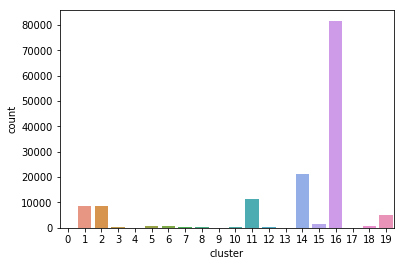

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_labels_customers = pd.DataFrame(labels_customers)
df_labels_customers.columns = ['cluster']

sns.countplot(x='cluster',data=df_labels_customers)



In [68]:
def get_cluster_data(df, columns, cluster, labels):
    pca_inverse = pca.inverse_transform(df[np.where(labels==cluster)])
    scaled_inverse = scaler.inverse_transform(pca_inverse).round()
    inverse_data = pd.DataFrame(
        data=scaled_inverse,
        index=np.array(range(0, scaled_inverse.shape[0])),
        columns=columns
    )
    
    return inverse_data.copy()

In [69]:
overrepresented_customers = get_cluster_data(subset_customers_pca,
                                             subset_customers_cleaned.columns, 
                                             16, 
                                             labels_customers)
overrepresented_customers.head(15)

# majority of these people is above 60 
# majority is male (58k compared to 22k female)
# the majority of these people is the opposite of a finanzminimalist (tendency very low), 
# but a finanzsparer 70k with tendency 1 or 2 (very high, high) and a finanzanleger (68k with tendency of very high or high)
# most of these people are critical reserved in terms of their health type
# who live in a mixed building without actually known household or company
# they are not green avantgarde
# unemployment average to high 
# primarily store shopper, also online shopper


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_4,GEBAEUDETYP_5,WOHNLAGE_0,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,WOHNLAGE_5,WOHNLAGE_6,WOHNLAGE_7
0,5.0,1.0,6.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0,...,2.0,-1.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,1.0,3.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0
2,4.0,1.0,6.0,0.0,6.0,0.0,1.0,2.0,0.0,2.0,...,1.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
3,4.0,1.0,6.0,1.0,5.0,1.0,1.0,2.0,0.0,1.0,...,2.0,-1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,1.0,0.0
4,4.0,1.0,6.0,1.0,5.0,1.0,2.0,2.0,0.0,1.0,...,1.0,-1.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0
5,3.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,0.0,1.0,...,2.0,-1.0,0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0
6,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,0.0,...,2.0,-1.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,1.0,...,2.0,-1.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0
8,4.0,1.0,5.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0,...,3.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0
9,4.0,1.0,5.0,4.0,2.0,3.0,5.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0


In [222]:
#overrepresented_customers['ALTERSKATEGORIE_GROB'].value_counts()
#overrepresented_customers['ANREDE_KZ'].value_counts()
#overrepresented_customers['FINANZ_MINIMALIST'].value_counts()
#overrepresented_customers['FINANZ_SPARER'].value_counts()
#overrepresented_customers['FINANZ_ANLEGER'].value_counts()
#overrepresented_customers['HEALTH_TYP'].value_counts()
#overrepresented_customers['ARBEIT'].value_counts()
#overrepresented_customers['CJT_GESAMTTYP_6'].value_counts()

In [71]:
underrepresented_population = get_cluster_data(subset_below_threshold_pca,
                                              subset_below_threshold_encoded.columns, 
                                              16,
                                              labels_population)

underrepresented_population.head(15)

# anreade_kz - very balanced - 2200 vs. 2300 
# alterskategorie majority in 3 or 4 - 46 - > 60 years old
# finanz_vorsorger - lots of 4s - rather low tendency 
# finanz_anleger - most 3.0 - average
# health type most fall in 2 or 3 which is either sanitary afine or jaunty hedonists
# Wealth - most fall in 3 or 4 - Prosperous / Comfortable Households
# LIFE_STAGE - most fall into 3 or 4 Families With School Age Children or Older Families &  Mature Couples
# most remaining columns are mixed so no clear obvious trends 
# unemployment average to high 
# CJT_GESAMTTYP_0 - unknown

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH,LIFE_STAGE,WOHNLAGE_0,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,WOHNLAGE_5,WOHNLAGE_6,WOHNLAGE_7
0,2.0,2.0,2.0,3.0,4.0,3.0,3.0,4.0,1.0,2.0,...,3.0,3.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0
1,2.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,0.0,3.0,...,4.0,4.0,0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0
2,3.0,1.0,5.0,2.0,4.0,2.0,2.0,1.0,0.0,3.0,...,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,1.0,4.0,3.0,3.0,3.0,3.0,2.0,0.0,2.0,...,2.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0
4,4.0,2.0,3.0,1.0,6.0,2.0,1.0,4.0,0.0,2.0,...,2.0,2.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0
5,4.0,2.0,3.0,1.0,4.0,3.0,0.0,5.0,0.0,1.0,...,2.0,5.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0
6,3.0,1.0,5.0,1.0,4.0,2.0,1.0,3.0,1.0,1.0,...,4.0,4.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0
7,2.0,1.0,3.0,5.0,2.0,4.0,5.0,2.0,1.0,2.0,...,5.0,4.0,-0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
8,3.0,2.0,3.0,4.0,2.0,5.0,5.0,3.0,-0.0,-0.0,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0
9,3.0,2.0,4.0,2.0,3.0,4.0,2.0,3.0,0.0,2.0,...,4.0,4.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0


In [210]:
# check for value counts to know the holistic set 
#underrepresented_population['ALTERSKATEGORIE_GROB'].value_counts()
#underrepresented_population['ANREDE_KZ'].value_counts()
#underrepresented_population['LIFE_STAGE'].value_counts()
#underrepresented_population['WEALTH'].value_counts()
#underrepresented_population['ARBEIT'].value_counts()
#underrepresented_population['CJT_GESAMTTYP_0'].value_counts()

1.0    4632
Name: CJT_GESAMTTYP_0, dtype: int64

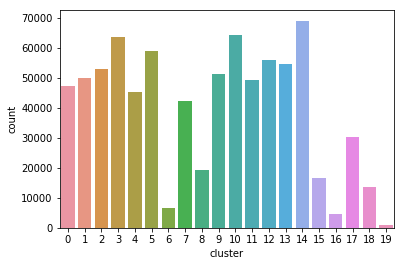

In [72]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

df_labels_population = pd.DataFrame(labels_population)
df_labels_population.columns = ['cluster']

sns.countplot(x='cluster', data=df_labels_population)


In [73]:
underrepresented_customers = get_cluster_data(subset_customers_pca,
                                              subset_customers_cleaned.columns,
                                              10,
                                              labels_customers)

underrepresented_customers.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_4,GEBAEUDETYP_5,WOHNLAGE_0,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,WOHNLAGE_5,WOHNLAGE_6,WOHNLAGE_7
0,2.0,2.0,3.0,2.0,4.0,3.0,1.0,4.0,0.0,2.0,...,0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0
1,2.0,2.0,1.0,3.0,3.0,4.0,3.0,5.0,0.0,1.0,...,2.0,1.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0
2,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,0.0,2.0,...,1.0,-1.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0
3,2.0,2.0,2.0,3.0,2.0,3.0,3.0,6.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0
4,2.0,2.0,2.0,2.0,4.0,2.0,4.0,5.0,0.0,1.0,...,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0
5,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,0.0,1.0,...,-0.0,-1.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0
6,2.0,2.0,2.0,3.0,4.0,3.0,2.0,5.0,0.0,1.0,...,-0.0,-1.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0
7,2.0,2.0,2.0,3.0,3.0,2.0,4.0,4.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0
8,2.0,2.0,2.0,3.0,2.0,3.0,4.0,5.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0
9,2.0,2.0,3.0,1.0,5.0,1.0,1.0,5.0,0.0,2.0,...,0.0,1.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0


In [201]:
#underrepresented_customers['ALTERSKATEGORIE_GROB'].value_counts()
#underrepresented_customers['ANREDE_KZ'].value_counts()
#underrepresented_customers['FINANZ_MINIMALIST'].value_counts()
#underrepresented_customers['FINANZ_SPARER'].value_counts()
#underrepresented_customers['FINANZ_ANLEGER'].value_counts()
#underrepresented_customers['FINANZ_HAUSBAUER'].value_counts()
#underrepresented_customers['HEALTH_TYP'].value_counts()
#underrepresented_customers['GREEN_AVANTGARDE'].value_counts()
#underrepresented_customers['WOHNLAGE_4'].value_counts()
#underrepresented_customers['WEALTH'].value_counts()
#underrepresented_customers['LIFE_STAGE'].value_counts()
#underrepresented_customers['ARBEIT'].value_counts()
#underrepresented_customers['CJT_GESAMTTYP_5'].value_counts()

In [140]:
overrepresented_population = get_cluster_data(subset_below_threshold_pca, 
                                              subset_below_threshold_encoded.columns,
                                              10,
                                              labels_population)
overrepresented_population.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH,LIFE_STAGE,WOHNLAGE_0,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,WOHNLAGE_5,WOHNLAGE_6,WOHNLAGE_7
0,1.0,2.0,0.0,5.0,2.0,5.0,4.0,4.0,-0.0,3.0,...,1.0,1.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0
1,1.0,2.0,1.0,5.0,2.0,4.0,4.0,5.0,0.0,2.0,...,1.0,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0
2,2.0,2.0,2.0,2.0,4.0,1.0,2.0,4.0,0.0,2.0,...,2.0,1.0,0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
3,1.0,2.0,1.0,5.0,2.0,5.0,4.0,4.0,0.0,2.0,...,4.0,5.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0
4,2.0,2.0,1.0,4.0,2.0,4.0,4.0,4.0,0.0,3.0,...,2.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0
5,1.0,2.0,1.0,5.0,2.0,4.0,4.0,5.0,0.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0
6,1.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,-0.0,2.0,...,2.0,2.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0
7,1.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,-0.0,2.0,...,2.0,5.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0
8,1.0,2.0,2.0,4.0,1.0,4.0,5.0,3.0,0.0,2.0,...,2.0,3.0,0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0
9,1.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,1.0,3.0,...,3.0,5.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0


In [191]:
#overrepresented_population['ALTERSKATEGORIE_GROB'].value_counts()
#overrepresented_population['ANREDE_KZ'].value_counts()
#overrepresented_population['FINANZ_MINIMALIST'].value_counts()
#overrepresented_population['FINANZ_SPARER'].value_counts()
#overrepresented_population['FINANZ_ANLEGER'].value_counts()
#overrepresented_population['FINANZ_HAUSBAUER'].value_counts()
#overrepresented_population['HEALTH_TYP'].value_counts()
#overrepresented_population['GREEN_AVANTGARDE'].value_counts()
#overrepresented_population['WOHNLAGE_'].value_counts()
#overrepresented_population['WEALTH'].value_counts()
#overrepresented_population['ARBEIT'].value_counts()
#overrepresented_population['CJT_GESAMTTYP_4'].value_counts()

In [134]:
# cluster 21 - missing and cut off data in the second data set for both customers and the population 

subset_customers_above_threshold = customers[customers.isnull().sum(axis=1)>missing_value_row_threshold]
subset_customers_above_threshold.head(15)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,-1,3,2,5.0,4,2,4,4,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,-1,1,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,-1,3,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,-1,2,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,-1,1,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,-1,3,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,-1,1,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,-1,1,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,-1,1,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
#subset_customers_above_threshold['ARBEIT'].value_counts()
#subset_customers_above_threshold['ALTERSKATEGORIE_GROB'].value_counts()
#subset_customers_above_threshold['ANREDE_KZ'].value_counts()
#subset_customers_above_threshold['FINANZ_MINIMALIST'].value_counts()
#subset_customers_above_threshold['FINANZ_SPARER'].value_counts()
#subset_customers_above_threshold['FINANZ_ANLEGER'].value_counts()
#subset_customers_above_threshold['FINANZ_HAUSBAUER'].value_counts()
#subset_customers_above_threshold['HEALTH_TYP'].value_counts()
#subset_customers_above_threshold['GREEN_AVANTGARDE'].value_counts()
#subset_customers_above_threshold['WOHNLAGE'].value_counts()
#subset_customers_above_threshold['CAMEO_INTL_2015'].value_counts()
#subset_customers_above_threshold['CJT_GESAMTTYP'].value_counts()

In [175]:
subset_above_threshold.head(15)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,2,3.0,4,3,4,4,4,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,2,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2,3.0,2,4,3,5,5,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,1,3.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Discussion 3.3: Compare Customer Data to Demographics Data

##### segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

**Popular**

"Overrepresented Customers"
* majority of these people is above 60 and male (58k compared to 22k female)
* They are the opposite of a finanzminimalist (tendency very low), hence, a finanzsparer (70k with tendency 1 or 2) (very high, high) and a finanzanleger (68k with tendency of very high or high)
* most of these people are critical reserved in terms of their health type
* live in a mixed building without actually known household or company
* they are not green avantgarde
* primarily store shopper and occassionally online shopper

Compared to "Underrepresented Population"
* anreade_kz - very balanced - 2200 vs. 2300 
* alterskategorie majority in 3 or 4 - 46 - > 60 years old
* finanz_vorsorger - lots of 4s - rather low tendency 
* finanz_anleger - most 3.0 - average
* health type most fall in 2 or 3 which is either sanitary afine or jaunty hedonists
* Wealth - most fall in 3 or 4 - Prosperous / Comfortable Households
* LIFE_STAGE - most fall into 3 or 4 Families With School Age Children or Older Families &  Mature Couples
* most remaining columns are mixed so no clear obvious trends 
* unemployment average to high 
* CJT_GESAMTTYP_0 - unknown

**Unpopular**

"Overrepresented Population"
* people who are between < 30 and 45, almost purely women
* they have a strong tendency to be finance minimalist, * no sparer, no vorsorger, no anleger and no hausbauer
* they health type falls in either  2: sanitary affine or 3: jaunty hedonists
* "Pre-Family Couples & Singles" or "Young Couples With Children" that live primarily in an average to good neighbourhood 
* They are either advertisinginterested Store-shopper, advertisinginterested Online-shopper, Ad-Enthusiast with restricted Cross-Channel-Behaviour - no strict tendency

Compared to "Underrepresented Customers"
* majority is female and between 30 and 45
* tendency to be a finanz_minimalist is between high and average, same for sparer and anleger
* very low to low tendency to be a "hausbauer"
* these women are also no green_avantgarde
* the majority is either 1: critical reserved or 2: sanitary affine in terms of their health type
* "Pre-Family Couples & Singles" and "Young Couples With Children" that live in an average neighbourhood
* prosporous and comfortable
* primarily advertisinginterested Store-shopper, but also online shopper

##### Cluster / set attributes 
Found in the different clusters of the population / customer sets as well as in the excluded sets with missing values above the selected threshold

Excluded sets

**Population**

* balanced in terms of male / female, most are 46 - 60 years old, followed by a smaller group of 30 - 45 years old
* unemployment low to average (compared to the other clusters where it was mostly average to high) 
* "Families With School Age Children" and "Older Families & Mature Couples"
* most live in an average neighborhood or in new building in rural neighborhood
* most are sanitary affine with their health type
* yet no green avantgarde
* low to very low tendency regarding finanz sparer, anleger and hausbauer
* average tendency to be a finanz minimalist
* They are particularly "Advertising-Enthusiast with restricted Cross-Channel-Behaviour"

**Customer**

* balanced female / male, majority < 30 years
* employment low to average (compare with population
* finance minimalists with low to very low tendency to be a sparer or anleger 
* average tendency to be a hausbauer
* health type of 1: critical reserved and -  2: sanitary affine 
* average neighborhood
* Pre-Family Couples & Singles and Young Families
* They are particularly "Advertising-Enthusiast with restricted Cross-Channel-Behaviour"

#### Conclusion
* works best with old male men
* works less good with younger to mature mothers in families
* excluded sets are somewhat similar but also different in terms of e.g., age groups. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.